In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Subset
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
from tqdm import tqdm
import numpy as np
import torchvision
import random
import torch
import time
import cv2
import os

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
data_root_path = "./drive/MyDrive/Pneumonia Detection using Chest X-rays/Dataset"

In [4]:
transform = {
    
    "Train": transforms.Compose([
                transforms.RandomAutocontrast(p=0.4),
                transforms.RandomAdjustSharpness(sharpness_factor=1.8, p=0.6),
                transforms.RandomHorizontalFlip(p=0.67),
                transforms.Resize([224,224]),
                transforms.ToTensor(),
            ]),
    
    "Test": transforms.Compose([
                transforms.Resize([224,224]),
                transforms.ToTensor(),
            ])
    
}

In [5]:
dataset = {
    mode: torchvision.datasets.ImageFolder(
        os.path.join(data_root_path, mode), 
        transform = transform[mode]
    )

    for mode in ["Train", "Test"]
}

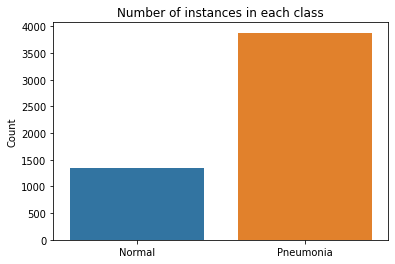

In [6]:
plt.title("Number of instances in each class")
sns.barplot(x=dataset["Train"].classes, y=[dataset["Train"].targets.count(0), dataset["Train"].targets.count(1)])
plt.ylabel("Count")
plt.show()

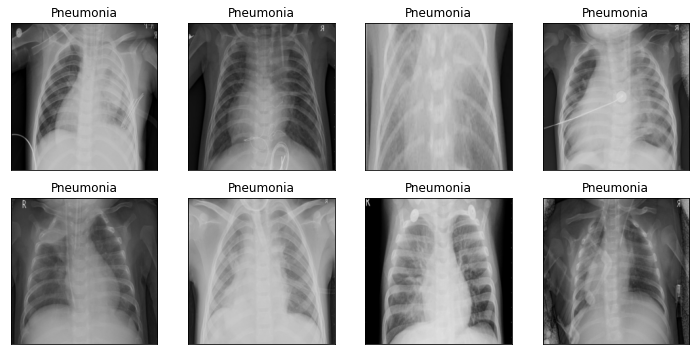

In [7]:
figure = plt.figure(figsize=(10,5))
rows, cols = 2, 4

for index, (image, label) in enumerate(DataLoader(dataset["Train"], batch_size=1, shuffle=True)):
    
    figure.add_subplot(rows, cols, index+1)
    plt.title(dataset["Train"].classes[label])
    plt.imshow(image.squeeze(0).permute(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
    if index == 7:
        break

plt.tight_layout()
plt.show()

In [13]:
class Network(torch.nn.Module):
    
    PATH = "./drive/MyDrive/Pneumonia Detection using Chest X-rays/logs"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    def __init__(
        
        self,
        model_name: str,
        num_classes: int,
        learning_rate: float = 1e-3,
        weight_decay: float = 1e-3,
        betas: tuple = (0.9, 0.999),
        batch_size: int = 48,
        epochs: int = 100,
        pretrained: bool = True
        
    ) -> None:
        
        super(Network, self).__init__()
        
        self.num_classes = num_classes
        
        # Hyperparameters
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.betas = betas
        self.batch_size = batch_size
        self.epochs = epochs
        
        # Model Declaration & Initialization

        if model_name == "VGG19":

          self.model = torchvision.models.vgg19(pretrained)
          
          in_neurons = self.model.classifier[-1].in_features
          out_neurons = num_classes
          
          output_layer = torch.nn.Linear(in_features=in_neurons, out_features=out_neurons, bias=True)
          
          updated_classifier = list(self.model.classifier.children())[:-1]
          updated_classifier.extend([output_layer])
          self.model.classifier = torch.nn.Sequential(*updated_classifier)
        
        elif model_name == "RESNET50":
          self.model = torchvision.models.resnet50(pretrained)

          in_neurons = self.model.fc.in_features
          out_neurons = num_classes

          self.model.fc = torch.nn.Linear(in_features=in_neurons, out_features=out_neurons, bias=True)

        self.model = self.model.to(self.device)
        
        # Loss Function
        self.loss = torch.nn.BCEWithLogitsLoss(reduction="mean")
        
        # Optimizer
        self.optimizer = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.learning_rate,
            betas=self.betas,
            weight_decay=self.weight_decay,
        )
        
        # Network Training Logs
        self.loss_logs = np.zeros(shape=(self.epochs, 2))
        self.accuracy_logs = np.zeros(shape=(self.epochs, 2))

    
    def fit(
        
        self,
        dataset: torchvision.datasets.folder.ImageFolder,
        train_valid_split: tuple = (0.85, 0.15)
        
    ) -> None:
        
        instances = len(dataset)
        train_set, valid_set = random_split(dataset, (np.array(train_valid_split)*instances).round().astype("int64"))
        
        best_accuracy = 0.0
        
        for epoch in range(self.epochs):
            
            model_name = "%0.2d-%s-%s" % (epoch+1, time.strftime("%d%m%Y"), time.strftime("%I%M%S"))

            train_loader = DataLoader(
                train_set,
                batch_size=self.batch_size,
                shuffle=True,
                drop_last=True
            )
            
            with tqdm(train_loader, unit="batch") as dataloader:
                
                dataloader.set_description(f"Epoch {epoch+1}")
                
                train_loss, train_accuracy = self.train(dataloader)

                self.loss_logs[epoch][0] = train_loss
                self.accuracy_logs[epoch][0] = train_accuracy

                print(f"Mean Entropy Loss (MEL): {train_loss}, Mean Training Accuracy (MTA): {train_accuracy}")
                torch.cuda.empty_cache()
                time.sleep(1)
            
            valid_loss, valid_accuracy = self.validate(valid_set)

            self.loss_logs[epoch][1] = valid_loss
            self.accuracy_logs[epoch][1] = valid_accuracy

            if valid_accuracy > best_accuracy:
                best_accuracy = valid_accuracy
                torch.save({
                        "epoch": epoch,
                        "model_state_dict": deepcopy(self.state_dict()),
                        "optimizer_state_dict": deepcopy(self.optimizer.state_dict()),
                        "accuracy_logs": self.accuracy_logs,
                        "loss_logs": self.loss_logs
                    }, 
                    self.PATH+"/"+model_name
                )
            
    def train(
        
        self,
        dataloader: DataLoader,
        
    ) -> tuple:
        
        self.model.train()
        loss, correct = 0, 0

        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(self.device), torch.zeros(len(y), self.num_classes).scatter_(1, y.to(torch.int64).reshape(-1, 1), 1).to(self.device)

            y_hat = self.model(X)

            train_loss = self.loss(y_hat, y)

            self.optimizer.zero_grad()
            train_loss.backward()
            self.optimizer.step()

            loss += train_loss.item()
            correct += (y.argmax(1) == y_hat.argmax(1)).sum().item()

            dataloader.set_postfix(loss=(loss/(batch+1)), accuracy=((correct/(self.batch_size*(batch+1)))*100))

            torch.cuda.empty_cache()
            time.sleep(0.1)

        return round(loss/len(dataloader), 3), round((correct/(self.batch_size*len(dataloader)))*100, 3)

    def validate(
        
        self,
        valid_set: Subset
    
    ) -> tuple:
        
        self.model.eval()
        valid_size = len(valid_set)
        dataloader = DataLoader(valid_set, batch_size=self.batch_size, drop_last=True, shuffle=True)
        loss, correct = 0, 0

        with torch.no_grad():

            for X, y in dataloader:

                X, y = X.to(self.device), torch.zeros(len(y), self.num_classes).scatter_(1, y.to(torch.int64).reshape(-1,1), 1).to(self.device)
                y_hat = self.model(X)
                loss = self.loss(y_hat, y).item()

                correct += (y.argmax(1) == y_hat.argmax(1)).sum().item()

            torch.cuda.empty_cache()

        accuracy = (correct / valid_size) * 100

        return round(loss, 3), round(accuracy, 3)
      
    def test(  
        
        self,
        dataset: torchvision.datasets.folder.ImageFolder

    ) -> tuple:
        
        dataloader = DataLoader(dataset, batch_size=self.batch_size, drop_last=False, shuffle=True)

        predictions = torch.tensor([]).to(self.device)
        ground_truths = torch.tensor([]).to(self.device)

        with torch.no_grad():
          
          for X, y in dataloader:
            
            X, y = X.to(self.device), torch.zeros(len(y), self.num_classes).scatter_(1, y.to(torch.int64).reshape(-1,1), 1).to(self.device)
            y_hat = self.model(X)

            ground_truths = torch.cat((ground_truths, y), dim=0)
            predictions = torch.cat((predictions, y_hat), dim=0)
          
          torch.cuda.empty_cache()
        
        return ground_truths.argmax(1).reshape(-1,1).cpu(), predictions.argmax(1).reshape(-1,1).cpu()

def display_test_results(

    ground_truths: torch.Tensor,
    predictions: torch.Tensor,
    display_confusion_matrix: bool = False

) -> None:

    matrix = confusion_matrix(ground_truths, predictions)

    if display_confusion_matrix:
        display_matrix = ConfusionMatrixDisplay(matrix, display_labels=["Normal", "Pneumonia"])
        display_matrix.plot(values_format="")
        plt.show()

    test_accuracy = round(((matrix[0][0] + matrix[1][1])/(matrix.sum())) * 100, 3)
    precision = round(matrix[0][0]/matrix[0,:].sum(), 3)
    recall = round(matrix[0][0]/matrix[:,0].sum(), 3)

    print(f"Test Accuracy: {test_accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
model = Network(
    model_name = "VGG19",
    num_classes = len(dataset["Train"].classes),
    learning_rate = 1e-3,
    weight_decay = 1e-3,
    betas = (0.9, 0.999),
    batch_size = 48,
    epochs = 15,
    pretrained = True
)

saved_model = torch.load("./drive/MyDrive/Pneumonia Detection using Chest X-rays/logs/15-17112021-030200", map_location=torch.device(device))

model.load_state_dict(saved_model["model_state_dict"])
model.optimizer.load_state_dict(saved_model["optimizer_state_dict"])
model.accuracy_logs = saved_model["accuracy_logs"]
model.loss_logs = saved_model["loss_logs"]

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

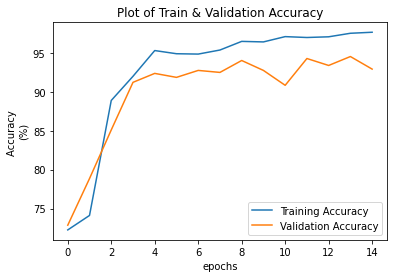

In [16]:
plt.title("Plot of Train & Validation Accuracy")
plt.plot(model.accuracy_logs[:,0], label="Training Accuracy")
plt.plot(model.accuracy_logs[:,1], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel("epochs")
plt.ylabel("Accuracy \n(%)")
plt.show()

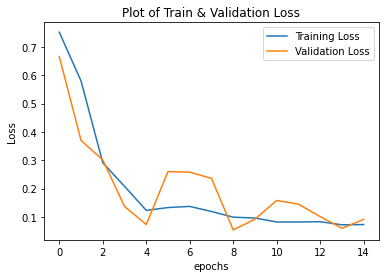

In [17]:
plt.title("Plot of Train & Validation Loss")
plt.plot(model.loss_logs[:,0], label="Training Loss")
plt.plot(model.loss_logs[:,1], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()

In [18]:
ground_truths, predictions = model.test(dataset["Test"])

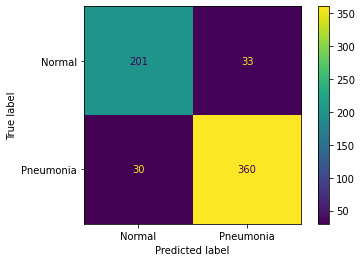

Test Accuracy: 89.904
Precision: 0.859
Recall: 0.87


In [24]:
display_test_results(
    ground_truths,
    predictions,
    display_confusion_matrix = True
)

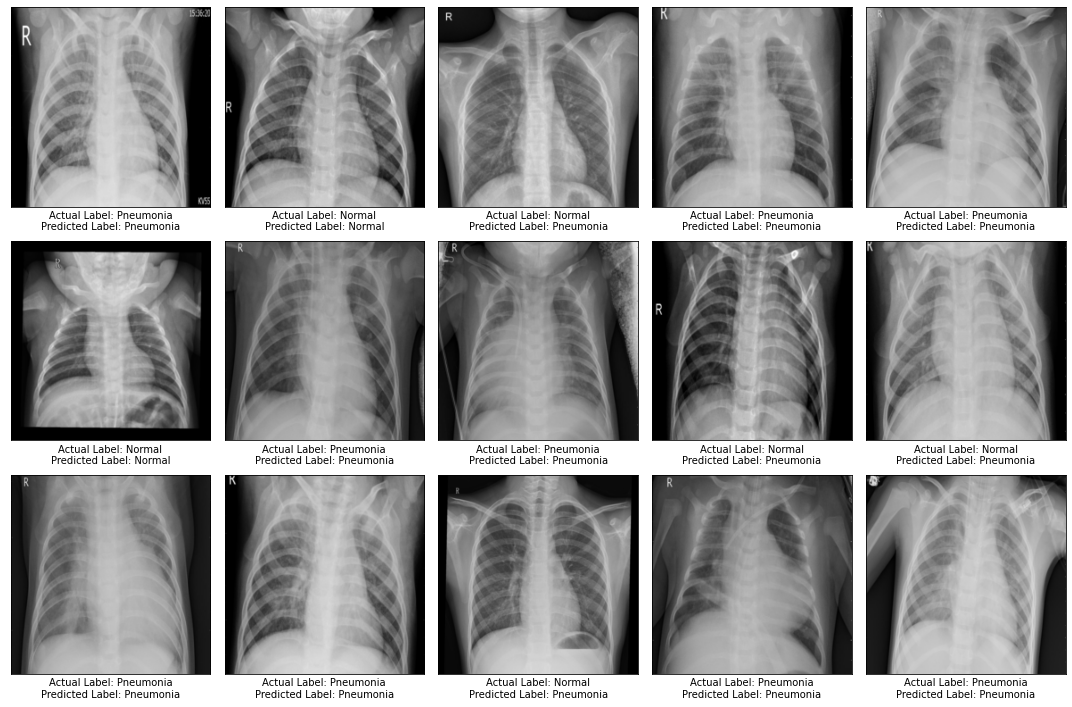

In [21]:
figure = plt.figure(figsize=(15,10))
rows, cols = 3, 5

for index, (image, label) in enumerate(DataLoader(dataset["Test"], batch_size=1, shuffle=True)):
    
    with torch.no_grad():
      pred = model.model(image.to(device))

    figure.add_subplot(rows, cols, index+1)
    plt.imshow(image.squeeze(0).permute(1,2,0))
    plt.xlabel(
        "Actual Label: " + dataset["Test"].classes[label] + "\n" +
        "Predicted Label: " + dataset["Test"].classes[pred.argmax(1).item()]
    )
    plt.xticks([])
    plt.yticks([])
    
    if index == 14:
        break

plt.tight_layout()
plt.show()

In [25]:
model = Network(
    model_name = "RESNET50",
    num_classes = len(dataset["Train"].classes),
    learning_rate = 1e-3,
    weight_decay = 1e-3,
    betas = (0.9, 0.999),
    batch_size = 48,
    epochs = 15,
    pretrained = True
)

saved_model = torch.load("./drive/MyDrive/Pneumonia Detection using Chest X-rays/logs/02-18112021-065850", map_location=torch.device(device))

model.load_state_dict(saved_model["model_state_dict"])
model.optimizer.load_state_dict(saved_model["optimizer_state_dict"])
model.accuracy_logs = saved_model["accuracy_logs"]
model.loss_logs = saved_model["loss_logs"]

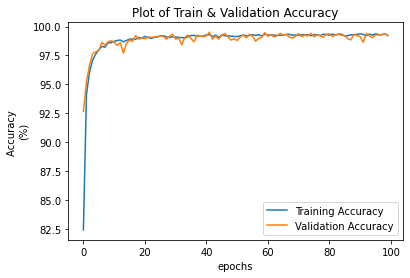

In [34]:
plt.title("Plot of Train & Validation Accuracy")
plt.plot(model.accuracy_logs[:,0], label="Training Accuracy")
plt.plot(model.accuracy_logs[:,1], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel("epochs")
plt.ylabel("Accuracy \n(%)")
plt.show()

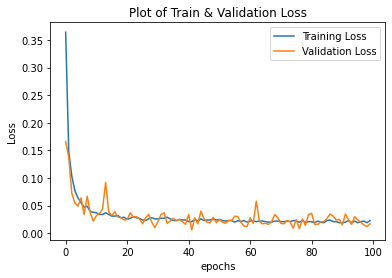

In [35]:
plt.title("Plot of Train & Validation Loss")
plt.plot(model.loss_logs[:,0], label="Training Loss")
plt.plot(model.loss_logs[:,1], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()

In [28]:
ground_truths, predictions = model.test(dataset["Test"])

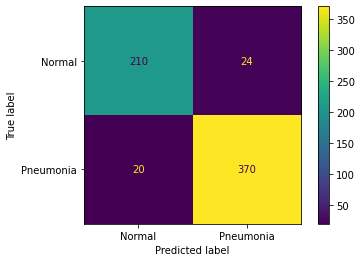

Test Accuracy: 92.949
Precision: 0.897
Recall: 0.913


In [32]:
display_test_results(
    ground_truths,
    predictions,
    display_confusion_matrix = True
)

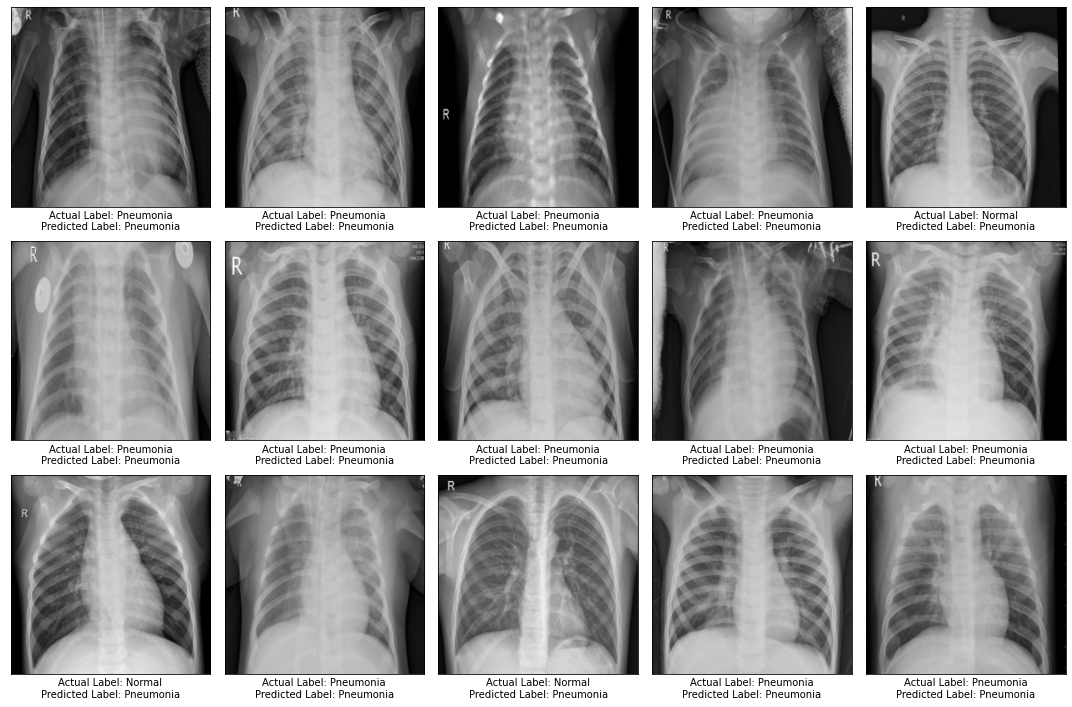

In [31]:
figure = plt.figure(figsize=(15,10))
rows, cols = 3, 5

for index, (image, label) in enumerate(DataLoader(dataset["Test"], batch_size=1, shuffle=True)):
    
    with torch.no_grad():
      pred = model.model(image.to(device))

    figure.add_subplot(rows, cols, index+1)
    plt.imshow(image.squeeze(0).permute(1,2,0))
    plt.xlabel(
        "Actual Label: " + dataset["Test"].classes[label] + "\n" +
        "Predicted Label: " + dataset["Test"].classes[pred.argmax(1).item()]
    )
    plt.xticks([])
    plt.yticks([])
    
    if index == 14:
        break

plt.tight_layout()
plt.show()